Bilayer unit domain. Sigma optimisation

In [1]:
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [2]:
import matplotlib.pyplot as plt

try:
	if "science" not in plt.style.available:
		try:
			import scienceplots  # registers styles if installed
		except Exception:
			# Install SciencePlots (registers the 'science' style) and import it
			get_ipython().run_line_magic('pip', 'install -q SciencePlots')
			import scienceplots  # noqa: F401
	plt.style.use(["science", "grid"])
except Exception as e:
	# If anything fails, fall back to a commonly available style
	print("Warning: 'science' style not available. Using 'seaborn' instead. Error:", e)
	plt.style.use("seaborn")

In [3]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
    dx,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, meshtags
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix, assemble_scalar
import basix
from dolfinx.geometry import bb_tree
from dolfinx import geometry
from petsc4py.PETSc import ScalarType
from slepc4py.SLEPc import EPS  

Domain, PML, refinement and physical configurations

In [4]:
# Define simulation parameters
# Mesh configuration
h = [0.125/2,   # N=1
      0.125/4,   # N=2
      0.125/8,] # N=3
N=[1,2,3]  # Mesh refinement levels
# Domain configuration
Lx = 1. # fluid domain length (without PML)
l_inner=Lx/2

# Physical configuration
rho_media_1 = 1. # kg/m^3 
vel_media_1 = 2.   # m/s
rho_media_2 = 1. # kg/m^3 
vel_media_2 = 1.   # m/s

# Define the density and velocity functions  
def rho_function(x):    
    return np.where(x[0] > l_inner, rho_media_2,rho_media_1)

def vel_function(x):    
    return np.where(x[0] > l_inner, vel_media_2,vel_media_1)

# PML configuration
pml_thickness = Lx/4

# Solver configuration
requested_eigenvalues_number = 15 # Number of eigenvalues to compute

degree=[2,1]  # Polynomial degree for pressure and velocity

target=[-12.56j, 
        -50.26j] # Shifts for the eigensolvers

pml_profile = "piecewise"  # 'quadratic' 'singular'

match pml_profile:
    case 'piecewise':
        sigma_sweep=sigma_sweep = np.arange(1, 102)  #np.linspace(1., 101., 21) #piecewise
    case 'quadratic':
        sigma_sweep=sigma_sweep = np.arange(50, 151) #np.linspace(1., 201., 21) #quadratic
    case 'singular':
        sigma_sweep=sigma_sweep = np.arange(0.5, 3.1, 0.5) #np.linspace(0.1, 3.1, 21)


Solver configuration and computing

In [5]:
def get_configured_problem(mesh, degrees, sigma_x, target):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Identify the fluid cells
    # fluid_cells = locate_entities(mesh, tdim, lambda x: x[0] <= Lx)

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs))

    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Define the subdomains using a Python function
    TOL = 1e-6
    def pml_domain(x):
        """Returns True for points in (Lx, Lx + pml_thickness]"""
        return x[0] > Lx - TOL

    # Get topology dimension
    tdim = mesh.topology.dim

    # Locate cells in each subdomain
    pml_cells = locate_entities(mesh, tdim, pml_domain)

    # Create a meshtag to mark the subdomains
    num_cells = mesh.topology.index_map(tdim).size_local
    cell_markers = np.ones(num_cells, dtype=np.int32) # Physical domain tag=1
    cell_markers[pml_cells] = 2       # PML domain tag=2

    cell_tags = meshtags(mesh, tdim, np.arange(num_cells, dtype=np.int32), cell_markers)

    # Now you can use these tags for integration measures
    dx = Measure("dx", domain=mesh, subdomain_data=cell_tags)

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs))

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 0))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q)
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx(2), -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx(2)],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-16, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert"
    solver.setTarget(target)
    solver.solve()
    n_eigs_converged_quadratic = solver.getConverged()

    return solver, mesh, Q, V, dof

In [6]:
def assign_eigenvector_to_functions(vrA, p_h, v_h, dof):
    """
    Reparte o vector eigenvector 'vrA' entre p_h e v_h
    e normaliza no punto 'normalize_at'.
    """

    # --- separar as partes do autovector ---
    p_vals = vrA[:dof["p"]]
    v_vals = vrA[dof["p"]:]

    # asignar
    p_h.x.array[:] = p_vals
    v_h.x.array[:] = v_vals

    return p_h, v_h

In [7]:
def get_exact_eigenpair(selected_index, Q, V, x_hat):
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    w=exact_physical_eigs_function(selected_index)

    # Función de presión en el primer medio
    p_1 = lambda x: np.sin(w * x / vel_media_1)

    # Valor de p_1 en la interfaz
    p_l_inner = p_1(l_inner)

    # Función de presión en el segundo medio, continua
    p_2 = lambda x: p_l_inner * np.exp(1j * w / vel_media_2 * (x_hat(x, w) - l_inner))

    # Función de presión completa
    p = lambda x: p_1(x[0]) + (x[0] >= l_inner) * (p_2(x[0]) - p_1(x[0]))

    # Velocidad en el primer medio
    def v_1(x):
        return ((-1j/(rho_media_1*vel_media_1)) * np.cos(w * x / vel_media_1))

    # Velocidad en el segundo medio, continua con la interfaz
    def v_2(x):
        return p_1(l_inner)/(rho_media_2*vel_media_2) * np.exp(1j * w / vel_media_2 * (x_hat(x, w) - l_inner))

    # Función de velocidad completa
    v = lambda x: v_1(x[0]) + (x[0] >= l_inner) * (v_2(x[0]) - v_1(x[0]))

    p_ex = Function(Q, name="p_ex")
    p_ex.interpolate(p)

    v_ex = Function(V, name="v_ex")
    v_ex.interpolate(v)

    return [w, p_ex, v_ex]

In [8]:
def eigenvector_L2_error_physical(u_num, u_exact, Lx, mesh):
    """
    Erro relativo L2 só no dominio físico [0, Lx] en DOLFINx 0.9.
    Alinea fase/signo antes de medir o erro.
    """

    import numpy as np
    import ufl
    from ufl import inner
    from dolfinx.mesh import locate_entities, meshtags
    from dolfinx.fem import form, assemble_scalar

    
    tdim = mesh.topology.dim
    # Define the subdomains using a Python function
    TOL = 1e-6
    def fluid_domain(x):
        """Returns True for points in [0, Lx]"""
        return np.logical_and(x[0] >= 0, x[0] < Lx + TOL)
    
    # --- 1) Localizar celas físicas ---
    cells_phys = locate_entities(
        mesh, tdim,
        fluid_domain
    )

    if len(cells_phys) == 0:
        raise RuntimeError("Non se detectaron celas na rexión física [0, Lx].")

    # Asignar etiqueta 1
    values = np.full(len(cells_phys), 1, dtype=np.int32)
    mt = meshtags(mesh, tdim, cells_phys, values)

    # Medida restrinxida
    dx_phys = ufl.Measure("dx", domain=mesh, subdomain_data=mt)
    
    # --- 3) Norma L2 do erro no dominio físico ---
    diff = u_num - u_exact

    num = np.sqrt(assemble_scalar(form(inner(diff, diff) * dx_phys(1))))
    den = np.sqrt(assemble_scalar(form(inner(u_exact, u_exact) * dx_phys(1))))

    return num / den


In [9]:
def get_exact_eigenpair(selected_index, Q, V, x_hat):
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    w=exact_physical_eigs_function(selected_index)

    # Función de presión en el primer medio
    p_1 = lambda x: np.sin(w * x / vel_media_1)

    # Valor de p_1 en la interfaz
    p_l_inner = p_1(l_inner)

    # Función de presión en el segundo medio, continua
    p_2 = lambda x: p_l_inner * np.exp(1j * w / vel_media_2 * (x_hat(x, w) - l_inner))

    # Función de presión completa
    p = lambda x: p_1(x[0]) + (x[0] >= l_inner) * (p_2(x[0]) - p_1(x[0]))

    # Velocidad en el primer medio
    def v_1(x):
        return ((-1j/(rho_media_1*vel_media_1)) * np.cos(w * x / vel_media_1))

    # Velocidad en el segundo medio, continua con la interfaz
    def v_2(x):
        return p_1(l_inner)/(rho_media_2*vel_media_2) * np.exp(1j * w / vel_media_2 * (x_hat(x, w) - l_inner))

    # Función de velocidad completa
    v = lambda x: v_1(x[0]) + (x[0] >= l_inner) * (v_2(x[0]) - v_1(x[0]))

    p_ex = Function(Q, name="p_ex")
    p_ex.interpolate(p)

    v_ex = Function(V, name="v_ex")
    v_ex.interpolate(v)

    return [w, p_ex, v_ex]

In [10]:
def eval_point_fast(u, bb, x, mesh):
    pt = np.array([x, 0.0, 0.0], dtype=np.float64)

    # 1) Buscamos celas candidatas no árbol
    candidates = geometry.compute_collisions_points(bb, pt)

    # 2) Filtramos celas que realmente conteñen o punto
    cell = geometry.compute_colliding_cells(mesh, candidates, pt)

    if len(cell) == 0:
        return np.nan

    # 3) Avaliar a función FEM
    P = np.array([pt])
    C = np.array([cell.array[0]], dtype=np.int32)

    val = u.eval(P, C)
    return val[0]

In [11]:
def normalize_at_Lx(u, bb, Lx, mesh):
    val_Lx = eval_point_fast(u, bb, Lx, mesh)
    u.x.array[:] /= val_Lx   # normalizando respecto do valor en [Lx, 0, 0]
    return u

In [12]:
def get_closest_approx_eigenpair(exact_eigenvalue_idx, solver, Q, V, dof, sigma_i, mesh, verbose=False, plot=False):
    """
    Devuelve el autovalor y autovector más cercano a omega_target
    usando distancia compleja |λ - λ_target|, sin usar get_approx_eigenpair.

    Returns
    -------
    lambda_best : complex
    x_best : PETSc.Vec (copia del autovector)
    idx_best : int (índice raw en solver)
    p_h:    Function
    v_h: Function
    """
    p_exact = [None] * 5  # Almacena los autovectores exactos de presión
    v_exact = [None] * 5  # Almacena los autovectores exactos de velocidad
    p_approx = [None] * 5  # Almacena los autovectores exactos de presión
    v_approx = [None] * 5  # Almacena los autovectores exactos de velocidad
    best = None
    best_3 = None

    # Vector temporal para extraer Eigenpairs
    p_h = Function(Q, name="p_h")
    v_h = Function(V, name="v_h")

    # Número de modos convergidos
    nconv = solver.getConverged()
    if nconv == 0:
        raise RuntimeError("No hay autovalores convergidos")

    # Vector temporal para extraer Eigenpairs
    vrA, vi = solver.getOperators()[0].getVecs()

    match pml_profile:
        case 'piecewise':
            x_hat = lambda x, w: x + (x >= Lx) * (1j / w) * sigma_i * (x - Lx)

        case 'quadratic':
            x_hat=lambda x, w: x + (x >= Lx) * (1j / w) * sigma_i* (x - Lx) ** 3/ (3 * pml_thickness**2)

        case 'singular':
            x_hat=lambda x, w: x + (x >= Lx) * (1j / w) * sigma_i *(-np.log((Lx + pml_thickness - x)/pml_thickness))

    [exact_eigenvalue, p_exact, v_exact] =   get_exact_eigenpair(exact_eigenvalue_idx, Q, V, x_hat)

    bb = bb_tree(mesh, mesh.topology.dim)
    for k in range(nconv):
        approx_eigenvalue = solver.getEigenvalue(k) * 1j
        solver.getEigenpair(k, vrA)
        # Vector temporal para extraer Eigenpairs
        p_h = Function(Q, name="p_h")
        v_h = Function(V, name="v_h")
        [p_h, v_h]=assign_eigenvector_to_functions(vrA = vrA, p_h = p_h, v_h = v_h, dof = dof)

        # --- autovalores ---
        err_eig = abs(approx_eigenvalue - exact_eigenvalue) / abs(exact_eigenvalue)

        # --- autovectores ---

        p_h=normalize_at_Lx(p_h, bb, Lx, mesh)
        v_h=normalize_at_Lx(v_h, bb, Lx, mesh)
        p_exact=normalize_at_Lx(p_exact, bb, Lx, mesh)
        v_exact=normalize_at_Lx(v_exact, bb, Lx, mesh)


        # Errores L2 en dominio físico
        err_p = eigenvector_L2_error_physical(p_h, p_exact, Lx, mesh)
        err_v = eigenvector_L2_error_physical(v_h, v_exact, Lx, mesh)

        # Total
        err = (err_eig + err_p + err_v) / 3


        if best is None or err < best[2]:
            best = (approx_eigenvalue, k, err,err_eig, err_p, err_v)

    closest_eig, idx_best, rel_err_total, rel_err_eig_best, rel_err_p_best, rel_err_v_best = best

    # Vector temporal para extraer Eigenpairs
    p_h = Function(Q, name="p_h")
    v_h = Function(V, name="v_h")
    vrA, vi = solver.getOperators()[0].getVecs()
    solver.getEigenpair(idx_best, vrA)
    [p_approx, v_approx]=assign_eigenvector_to_functions(vrA = vrA, p_h = p_h, v_h = v_h, dof = dof)

    if verbose:
        print(f"$\sigma_i={sigma_i}$")
        print(f"$[Closest to \omega={exact_eigenvalue}] idx={idx_best}  \omega={closest_eig}  \epsilon_r={(rel_err_eig_best+rel_err_p_best+rel_err_v_best)/3} \epsilon_r(\omega)={rel_err_eig_best}  \epsilon_r(p)={rel_err_p_best} \epsilon_r(v)={rel_err_v_best}$")


    if plot:
        from dolfinx import geometry

        fig, axes = plt.subplots(1, 2, figsize=(12,8))

        # ============================================================
        #  FILA 1 — AUTOVECTORES p
        # ============================================================

        # --- p, modo 0 ---
        ax = axes[0]


        val_Lx = eval_point_fast(p_approx, bb, Lx, mesh)
        p_approx.x.array[:] /= val_Lx   # normalizando respecto do valor en [Lx, 0, 0]
        val_Lx = eval_point_fast(p_exact, bb, Lx, mesh)
        p_exact.x.array[:] /= val_Lx
        xx = np.linspace(0, Lx+pml_thickness, 2000)
        yy = [eval_point_fast(p_approx, bb, x, mesh) for x in xx]
        ax.plot(xx, np.real(yy), label="Re(p)", linestyle="-.")
        yy = [eval_point_fast(p_exact, bb, x, mesh) for x in xx]
        ax.plot(xx, np.real(yy), label="Re(p)", linestyle="-")
        ax.set_xlabel("x [m]")
        ax.set_ylabel("p(x) [Pa]")
        ax.set_title("Modo {} con sigma singular".format(0))
        ax.grid(True)


        ax = axes[1]
        val_Lx = eval_point_fast(v_approx, bb, Lx, mesh)
        v_approx.x.array[:] /= val_Lx   # normalizando respecto do valor en [Lx, 0, 0]
        val_Lx = eval_point_fast(v_exact, bb, Lx, mesh)
        v_exact.x.array[:] /= val_Lx
        xx = np.linspace(0, Lx+pml_thickness, 2000)
        yy = [eval_point_fast(v_approx, bb, x, mesh) for x in xx]
        ax.plot(xx, np.real(yy), label="Re(v)", linestyle="-.")
        yy = [eval_point_fast(v_exact, bb, x, mesh) for x in xx]
        ax.plot(xx, np.real(yy), label="Re(v)", linestyle="-")
        ax.set_xlabel("x [m]")
        ax.set_ylabel("v(x) ")
        ax.grid(True)

        plt.show()

    return exact_eigenvalue, p_exact, v_exact, closest_eig, p_approx, v_approx, rel_err_eig_best, rel_err_p_best, rel_err_v_best, (rel_err_eig_best + rel_err_p_best + rel_err_v_best) / 3


In [13]:
# Diccionarios onde gardar os erros para cada refinamento N
rel_err_eig_sigma_sweep = {0: {}, 3: {}}   # erros para modo 0 e 3
rel_err_p_sigma_sweep = {0: {}, 3: {}}   # erros para modo 0 e 3
rel_err_v_sigma_sweep = {0: {}, 3: {}}   # erros para modo 0 e 3
rel_err_total_sigma_sweep = {0: {}, 3: {}}   # erros para modo 0 e 3

approx_omega  = {0: {}, 3: {}}
approx_p      = {0: {}, 3: {}}
approx_v      = {0: {}, 3: {}}
exact_p      = {0: {}, 3: {}}
exact_v      = {0: {}, 3: {}}
exact_omega  = {0: {}, 3: {}}

# Iterar sobre N = 0,1,2 → corresponde a h_i[0], h_i[1], h_i[2]
for N_i, h_i in zip(N, h):

    print(f"\n=== Executando para N = {N_i}, h = {h_i} ===")

    # Inicializar listas baleiras para este N
    rel_err_eig_sigma_sweep[0][N_i] = []
    rel_err_eig_sigma_sweep[3][N_i] = []
    rel_err_p_sigma_sweep[0][N_i] = []
    rel_err_p_sigma_sweep[3][N_i] = []
    rel_err_v_sigma_sweep[0][N_i] = []
    rel_err_v_sigma_sweep[3][N_i] = []
    rel_err_total_sigma_sweep[0][N_i] = []
    rel_err_total_sigma_sweep[3][N_i] = []
    

    approx_omega[0][N_i] = []
    approx_omega[3][N_i] = []

    approx_p[0][N_i] = []
    approx_p[3][N_i] = []
    approx_v[0][N_i] = []
    approx_v[3][N_i] = []

    exact_p[0][N_i] = []
    exact_p[3][N_i] = []

    exact_v[0][N_i] = []
    exact_v[3][N_i] = []

    exact_omega[0][N_i] = []
    exact_omega[3][N_i] = []

    # Crear nova malla para este refinamento
    mesh = create_interval(
        MPI.COMM_WORLD,
        int((Lx + pml_thickness) / h_i),
        [0, Lx + pml_thickness]
    )

    # Percorrer sigma_sweep_piecewise
    for i, sigma_i in enumerate(sigma_sweep):
        match pml_profile:
            case 'piecewise':
                print(f"Computing for sigma_i = {sigma_i:.2f} (piecewise)")
                sigma_function = lambda x: sigma_i
            case 'quadratic':
                print(f"Computing for sigma_i = {sigma_i:.2f} (quadratic)")
                sigma_function = lambda x: sigma_i * (x[0] - Lx)**2 / (pml_thickness**2)
            case 'singular':
                print(f"Computing for sigma_i = {sigma_i:.2f} (singular)")
                sigma_function = lambda x: sigma_i/(Lx+pml_thickness-x[0])

        sigma_piecewise_ufl = lambda x: sigma_i
        solver_target_0, mesh, Q_, V_, dof_ = get_configured_problem(mesh, degree, sigma_function, target[0])
        solver_target_3, mesh, Q_, V_, dof_ = get_configured_problem(mesh, degree, sigma_function, target[1])
        (eig_ex0, p_ex0, v_ex0, eig0, p0, v0, err0_eig, err0_p, err0_v, total_error) = get_closest_approx_eigenpair(1, solver_target_0, Q_, V_, dof_, sigma_i, mesh,verbose=True, plot=False)
        (eig_ex3, p_ex3, v_ex3, eig3, p3, v3, err3_eig, err3_p, err3_v, total_error) = get_closest_approx_eigenpair(4, solver_target_3, Q_, V_, dof_, sigma_i, mesh,verbose=True, plot=False)

        err0 = (err0_eig + err0_p + err0_v ) /3
        err3 = (err3_eig + err3_p + err3_v) / 3
        # Gardar resultados
        approx_omega[0][N_i].append(eig0)
        approx_omega[3][N_i].append(eig3)

        exact_omega[0][N_i].append(eig_ex0)
        exact_omega[3][N_i].append(eig_ex3)
        approx_p[0][N_i].append(p0)
        approx_p[3][N_i].append(p3)

        approx_v[0][N_i].append(v0)
        approx_v[3][N_i].append(v3)

        exact_p[0][N_i].append(p_ex0)
        exact_p[3][N_i].append(p_ex3)

        exact_v[0][N_i].append(v_ex0)
        exact_v[3][N_i].append(v_ex3)


        rel_err_eig_sigma_sweep[0][N_i].append(err0_eig)
        rel_err_eig_sigma_sweep[3][N_i].append(err3_eig)

        rel_err_p_sigma_sweep[0][N_i].append(err0_p)
        rel_err_p_sigma_sweep[3][N_i].append(err3_p)

        rel_err_v_sigma_sweep[0][N_i].append(err0_v)
        rel_err_v_sigma_sweep[3][N_i].append(err3_v)

        rel_err_total_sigma_sweep[0][N_i].append(err0)
        rel_err_total_sigma_sweep[3][N_i].append(err3)


=== Executando para N = 1, h = 0.0625 ===
Computing for sigma_i = 1.00 (piecewise)
$\sigma_i=1$
$[Closest to \omega=(12.566370614359172-2.197224577336219j)] idx=2  \omega=(15.377060721036484-0.25708293249348163j)  \epsilon_r=(1.3923579065101803+0j) \epsilon_r(\omega)=0.26771766904494626  \epsilon_r(p)=(2.081846952499933+0j) \epsilon_r(v)=(1.8275090979856616+0j)$
$\sigma_i=1$
$[Closest to \omega=(50.26548245743669-2.197224577336219j)] idx=7  \omega=(63.95901379656589-0.22368051254098942j)  \epsilon_r=(1.2617834715016225+0j) \epsilon_r(\omega)=0.2749763211389986  \epsilon_r(p)=(1.749501973560145+0j) \epsilon_r(v)=(1.7608721198057247+0j)$
Computing for sigma_i = 2.00 (piecewise)
$\sigma_i=2$
$[Closest to \omega=(12.566370614359172-2.197224577336219j)] idx=2  \omega=(15.369376168118034-0.5145849915567232j)  \epsilon_r=(1.2747396004070688+0j) \epsilon_r(\omega)=0.2562721835385567  \epsilon_r(p)=(1.922712122020731+0j) \epsilon_r(v)=(1.6452344956619191+0j)$
$\sigma_i=2$
$[Closest to \omega=(

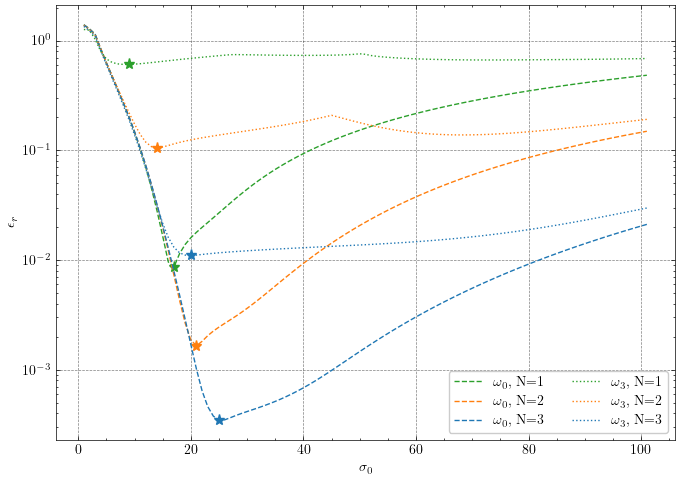

: 

In [ ]:
colors = ['tab:green', 'tab:orange', 'tab:blue']
linestyles = {0: '--', 3: ':'}
labels = {0: r'$\omega_0$', 3: r'$\omega_3$'}

fig, ax = plt.subplots(figsize=(7, 5))

key = 'tot'   # ← só total
err_tot = rel_err_total_sigma_sweep

for j in [0, 3]:            # modos físicos
    for i, N_index in enumerate(N):
        col = colors[i % len(colors)]
        ls = linestyles[j]

        errs = err_tot[j][N_index]

        ax.plot(
            sigma_sweep,
            errs,
            color=col,
            linestyle=ls,
            label=f"{labels[j]}, N={N_index}"
        )

        # mínimo
        k = np.argmin(errs)
        ax.plot(
            sigma_sweep[k],
            errs[k],
            '*',
            color=col,
            markersize=8
        )

ax.set_yscale('log')
ax.set_xlabel(r'$\sigma_0$')
ax.set_ylabel(r'$\epsilon_r$')
ax.grid(True)

# lenda sen duplicados
handles, labels_leg = ax.get_legend_handles_labels()
by_label = dict(zip(labels_leg, handles))
ax.legend(by_label.values(), by_label.keys(), ncol=2)

# plt.suptitle(
#     f'$\sigma_0$ optimization depending on $\omega$ and N values. PML profile {pml_profile}.',
#     fontsize=14
# )

plt.tight_layout()
# plt.savefig(f"sigma_optimization_total_{pml_profile}.png", dpi=300)
plt.savefig(f"1D_bicapa_optimo_{pml_profile}.pdf", dpi=300)

plt.show()


In [ ]:
eig_number=0  # modo físico 0
N_i=N[0]         # refinamento N=4 (0,1,2 → 2,3,4)

sigma_of_interest=1
indice = np.argmin(np.abs(sigma_sweep - sigma_of_interest))
print("Sigma of interest: ", sigma_sweep[indice])
print("Relative error total: ", rel_err_total_sigma_sweep[eig_number][N_i][indice])

sigma_0=sigma_sweep[indice]

idx_min_err = np.argmin(rel_err_total_sigma_sweep[eig_number][N_i])
p_approx = approx_p[eig_number][N_i][indice]
v_approx = approx_v[eig_number][N_i][indice]
p_exact = exact_p[eig_number][N_i][indice]
v_exact = exact_v[eig_number][N_i][indice]

mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness) / h[N_i]), [0, Lx + pml_thickness])

bb = bb_tree(mesh, mesh.topology.dim)

# Extract FunctionSpace objects from the approximated functions
Q = p_approx.ufl_function_space()
V = v_approx.ufl_function_space()

fig, axes = plt.subplots(1, 2, figsize=(12,8))
# --- p, modo 0 ---
ax = axes[0]
xx = np.linspace(0, Lx+pml_thickness, 100)
yy = [eval_point_fast(p_exact, bb, x, mesh) for x in xx]
ax.plot(xx, np.real(yy), label="Re(p)", linestyle="-")
yy = [eval_point_fast(p_approx, bb, x, mesh) for x in xx]
ax.plot(xx, np.real(yy), label="Re(p)", linestyle="-.")
ax.set_xlabel("x [m]")
ax.set_ylabel("p(x) [Pa]")
ax.grid(True)


ax = axes[1]
xx = np.linspace(0, Lx+pml_thickness, 100)
yy = [eval_point_fast(v_exact, bb, x, mesh) for x in xx]
ax.plot(xx, np.real(yy), label="Re(v)", linestyle="-")        
yy = [eval_point_fast(v_approx, bb, x, mesh) for x in xx]
ax.plot(xx, np.real(yy), label="Re(v)", linestyle="-.")
ax.set_xlabel("x [m]")
ax.set_ylabel("v(x) ")
ax.grid(True)
fig.suptitle("Sigma {pml_profile} - Modo {eig}, N={N_i}, sigma={sigma_0}".format(pml_profile=pml_profile, eig=eig_number, N_i=N_i, sigma_0=sigma_0))
plt.show()


In [ ]:
from scipy.io import savemat

savemat(
    "results_sigma_optimization_{pml_profile}.mat",
    {
        "pml_thickness": pml_thickness,
        "Lx": Lx,
        "l_inner": l_inner,
        "rho_media1": rho_media_1,
        "rho_media_2": rho_media_2,
        "vel_media_1": vel_media_1,
        "vel_media_2": vel_media_2,
        "sigma_sweep": sigma_sweep,
        "rel err eig": rel_err_eig_sigma_sweep,
        "rel error p": rel_err_p_sigma_sweep,
        "rel error v": rel_err_v_sigma_sweep,
        "rel error total": rel_err_total_sigma_sweep,
        "approx_p": approx_p,
        "approx_v": approx_v,
        "approx_omega": approx_omega,
        "sigma_piecewise_ufl": sigma_piecewise_ufl,
        "target": target,
    }
)
